In [1]:
import os
import requests
import zipfile
import pandas as pd
import pandas as np
import geopandas as gpd
from shapely.geometry import Point
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [2]:
# downloading LSOA data
src = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/LSOA_IMD.zip?raw=true'
dst = 'data/LSOA_IMD.zip'
zpd = 'data/'

if not os.path.exists(dst):
    if not os.path.exists(os.path.dirname(dst)):
        os.makedirs(os.path.dirname(dst))
    
    r = requests.get(src, stream=True)
    
    with open(dst, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)

if not os.path.exists(zpd):
    os.makedirs(os.path.dirname(zpd))
    
zp = zipfile.ZipFile(dst, 'r')
zp.extractall(zpd)
zp.close()    

print("LSOA data is downloaded.")

LSOA data is downloaded.


In [3]:
# LSOA data
lsoas = gpd.read_file(os.path.join('data','LSOA_IMD','LSOA_IMD2019.shp'))
print("Shape of LSOA file: {0} rows by {1} columns".format(lsoas.shape[0], lsoas.shape[1]))
# Airbnb data
listings = pd.read_csv('./data/listings.csv')
print("Shape of listings file: {0} rows by {1} columns".format(listings.shape[0], listings.shape[1]))

Shape of LSOA file: 4835 rows by 43 columns
Shape of listings file: 76534 rows by 74 columns


In [4]:
# clean listings data
keep_list = ['id', 'host_response_rate',
       'host_acceptance_rate',
       'host_identity_verified', 'neighbourhood', 
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
        'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable']
listings = listings[keep_list]

In [5]:
# add geometry to gdf
geometry = [Point(xy) for xy in zip(listings.longitude, listings.latitude)]
crs = {'init': 'epsg:4326'}
sdf = gpd.GeoDataFrame(listings, crs=crs, geometry=geometry)
sdf = sdf.to_crs({'init': 'epsg:27700'})
print("Shape of sdf file: {0} rows by {1} columns".format(sdf.shape[0], sdf.shape[1]))

Shape of sdf file: 76534 rows by 26 columns


In [6]:
# clean lsoas gdf
lsoas['Borough'] = lsoas.LSOA11NM.str.replace('\d\d\d\w$', '', case=False)
# lsoas.groupby('Borough').size()
drop_col = ['IMD2019_LS', 'IMD2019__1', 'IMD2019_Lo',
       'IMD2019__2', 'IMD2019_In', 'IMD2019__3', 'IMD2019__4', 'IMD2019__5',
       'IMD2019__6', 'IMD2019__7', 'IMD2019_Em', 'IMD2019__8', 'IMD2019__9',
       'IMD2019_Ed', 'IMD2019_10', 'IMD2019_11', 'IMD2019_He', 'IMD2019_12',
       'IMD2019_13', 'IMD2019_Cr', 'IMD2019_14', 'IMD2019_15', 'IMD2019_Ba',
       'IMD2019_16', 'IMD2019_17', 'IMD2019_Li', 'IMD2019_18', 'IMD2019_19', 
       'USUALRES', 'HHOLDRES', 'COMESTRES','HHOLDS', 'AVHHOLDSZ']
lsoas = lsoas.drop(columns = drop_col)
lsoas = lsoas.to_crs( {'init': 'epsg:27700'} )
print("Airbnb CRS: " + str(sdf.crs))
print("LSOAs CRS: " + str(lsoas.crs))

Airbnb CRS: +init=epsg:27700 +type=crs
LSOAs CRS: epsg:27700


In [7]:
# spatial join: filter the airbnb point that is in GLA
airbnb = gpd.sjoin(sdf, lsoas, how="inner", op='within')
print("Shape of airbnb file: {0} rows by {1} columns".format(airbnb.shape[0], airbnb.shape[1]))

Shape of airbnb file: 76514 rows by 37 columns


In [8]:
# clean airbnb gdf
airbnb['neighbourhood'] = airbnb.neighbourhood.str.strip()
airbnb['Borough'] = airbnb.Borough.str.strip()
airbnb['neighbourhood'] = airbnb.neighbourhood.str.replace('LB of ','').str.replace('RB of','')
for c in ['host_response_rate','host_acceptance_rate']:
    airbnb[c] = airbnb.loc[:,(c)].str.replace("%",'').astype(float).apply(lambda x: x/100).fillna(0)
for c in ['LSOA11CD', 'LSOA11NM', 'MSOA11CD','MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'Borough']:
    airbnb[c] = airbnb[c].astype('str')
for c in ['host_identity_verified','instant_bookable']:
    airbnb[c] = airbnb[c].apply(lambda x: True if x == 't' else False)
for c in ['bedrooms','beds','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']:
    airbnb[c] = airbnb[c].fillna(0)
airbnb['amenities'] = airbnb.amenities.apply(len)
airbnb = airbnb.fillna(False)
airbnb['price'] = airbnb.loc[:,('price')].str.replace("$",'').str.replace(",",'').astype(float)

In [9]:
# check nan
airbnb.columns[airbnb.isna().any()]

Index([], dtype='object')

In [10]:
# check type
airbnb.dtypes

id                                int64
host_response_rate              float64
host_acceptance_rate            float64
host_identity_verified             bool
neighbourhood                    object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bedrooms                        float64
beds                            float64
amenities                         int64
price                           float64
minimum_nights                    int64
maximum_nights                    int64
number_of_reviews                 int64
review_scores_rating            float64
review_scores_accuracy          float64
review_scores_cleanliness       float64
review_scores_checkin           float64
review_scores_communication     float64
review_scores_location          float64
review_scores_value             float64
instant_bookable                   bool


In [11]:
# lsoas['num_airbnb'] = lsoas['geometry'].apply(lambda x: len(airbnb[airbnb['geometry'].within(x)]))

In [12]:
airbnb.CRS= "+proj=longlat +ellps=EPSG:27700 +datum=WGS84 +no_defs"
# airbnb.to_file('./output/airbnb.shp', driver='ESRI Shapefile')
lsoas.CRS= "+proj=longlat +ellps=EPSG:27700 +datum=WGS84 +no_defs"
# lsoas.to_file('./output/lsoas.shp', driver='ESRI Shapefile')

In [13]:
print(lsoas.crs)
print(airbnb.crs)

epsg:27700
+init=epsg:27700 +type=crs


In [14]:
lsoas_count = gpd.read_file('./data/lsoa_count_airbnb.shp')[['LSOA11CD','NUMPOINTS']]

In [15]:
lsoas = lsoas.merge(lsoas_count, left_on='LSOA11CD', right_on='LSOA11CD')

In [16]:
lsoas.head(1)

LSOA11CD             LSOA11NM   MSOA11CD            MSOA11NM    LAD11CD  \
0  E01000001  City of London 001A  E02000001  City of London 001  E09000001   

          LAD11NM    RGN11CD RGN11NM  POPDEN  \
0  City of London  E12000007  London   112.9   

                                            geometry          Borough  \
0  POLYGON ((532105.092 182011.230, 532162.491 18...  City of London    

   NUMPOINTS  
0       16.0

In [17]:
print(lsoas.crs)

epsg:27700


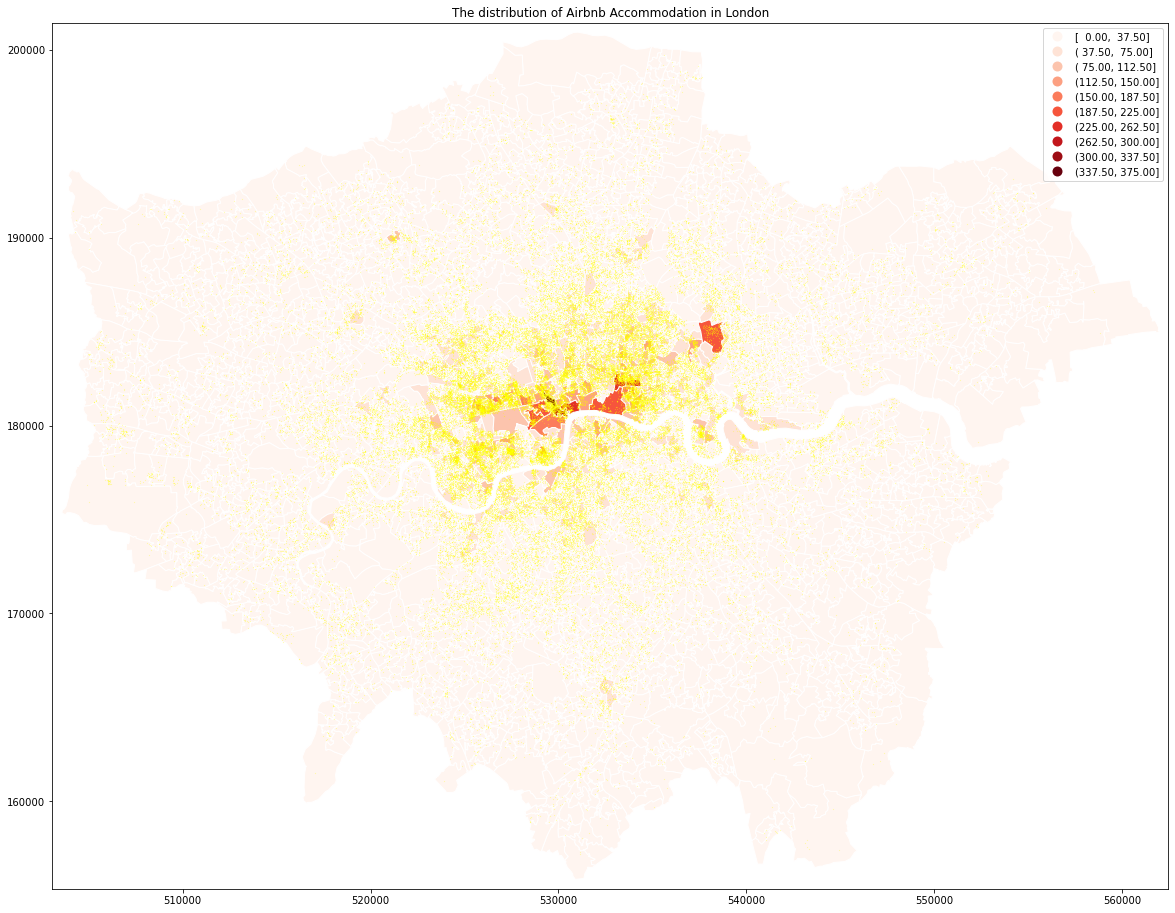

In [18]:
# plot: distribution of airbnb point
figsize(20, 20)

base = lsoas.plot(column='NUMPOINTS', cmap=plt.cm.Reds, k = 10, alpha=1,scheme='equal_interval', edgecolor='white', linewidth=1, legend=True)
airbnb.plot(ax=base, marker='o', color='yellow', markersize=0.01)

bounds = lsoas.geometry.bounds
plt.xlim([bounds.minx.min()-500, bounds.maxx.max()+500])
plt.ylim([bounds.miny.min()-500, bounds.maxy.max()+500])
# ax.set_axis_off()
plt.title("The distribution of Airbnb Accommodation in London")
# plt.show()
plt.savefig('./output/equal.png')

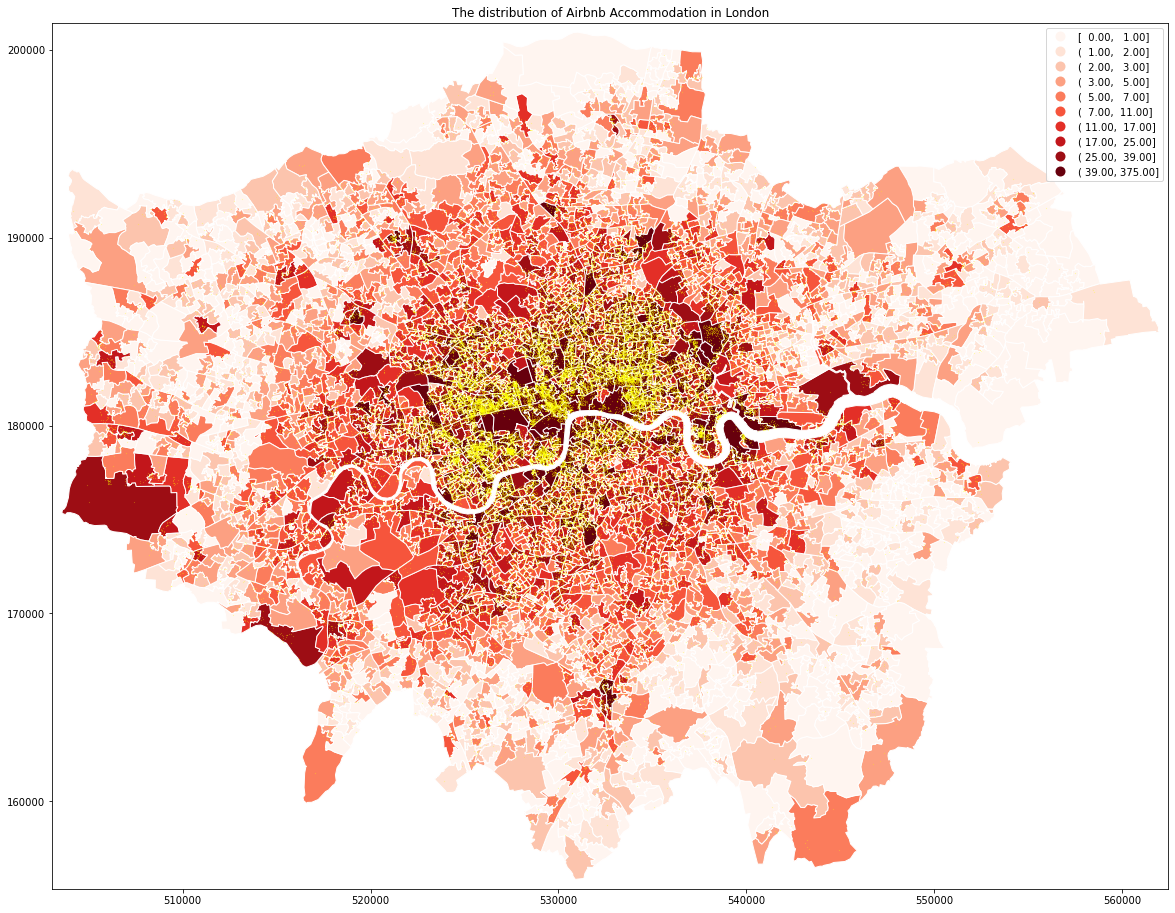

In [19]:
# plot: distribution of airbnb point
figsize(20, 20)

base = lsoas.plot(column='NUMPOINTS', cmap=plt.cm.Reds, k = 10, alpha=1,scheme='QUANTILES', edgecolor='white', linewidth=1, legend=True)
airbnb.plot(ax=base, marker='o', color='yellow', markersize=0.01)

bounds = lsoas.geometry.bounds
plt.xlim([bounds.minx.min()-500, bounds.maxx.max()+500])
plt.ylim([bounds.miny.min()-500, bounds.maxy.max()+500])
# ax.set_axis_off()
plt.title("The distribution of Airbnb Accommodation in London")
# plt.show()
plt.savefig('./output/QUANTILES.png')

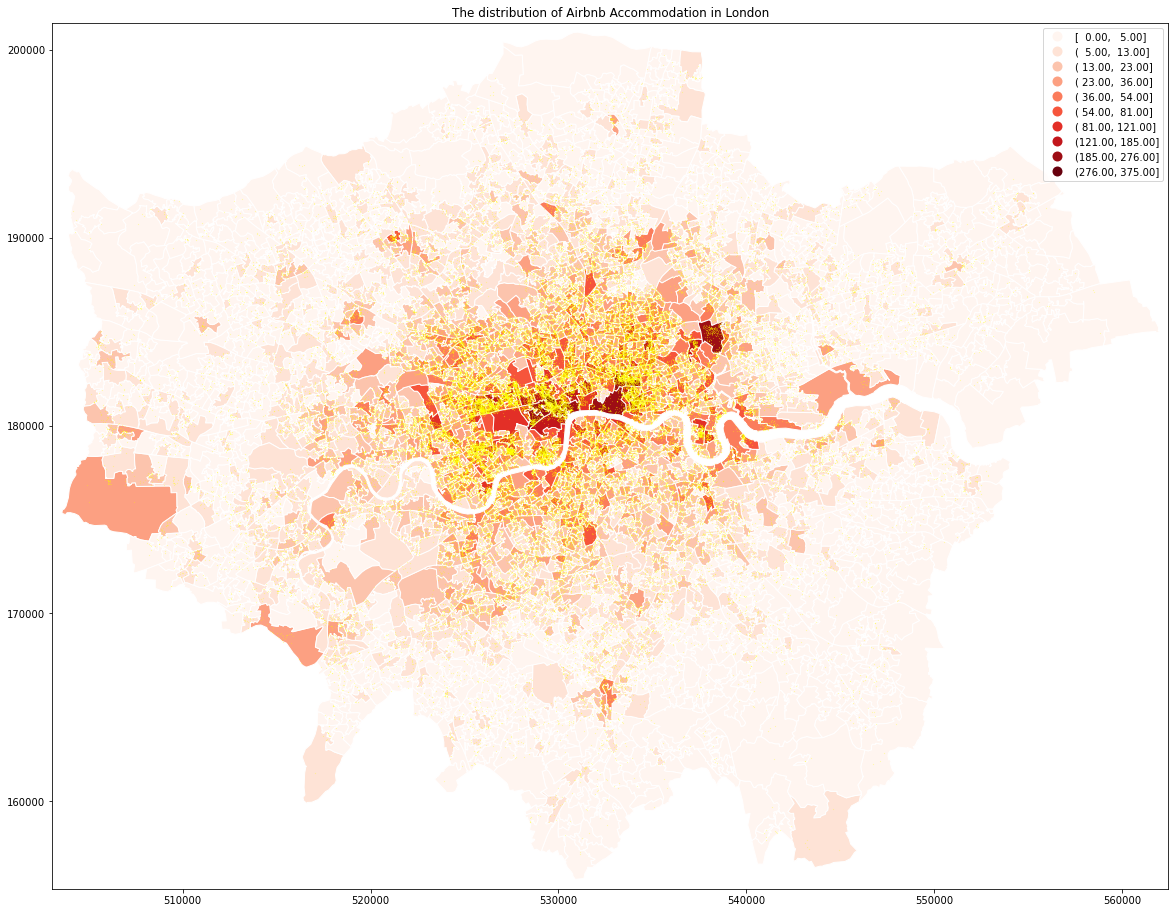

In [20]:
# plot: distribution of airbnb point
figsize(20, 20)

base = lsoas.plot(column='NUMPOINTS', cmap=plt.cm.Reds, k = 10, alpha=1,scheme='fisher_jenks', edgecolor='white', linewidth=1, legend=True)
airbnb.plot(ax=base, marker='o', color='yellow', markersize=0.01)

bounds = lsoas.geometry.bounds
plt.xlim([bounds.minx.min()-500, bounds.maxx.max()+500])
plt.ylim([bounds.miny.min()-500, bounds.maxy.max()+500])
# ax.set_axis_off()
plt.title("The distribution of Airbnb Accommodation in London")
# plt.show()
plt.savefig('./output/distribution_airbnb.png')

In [21]:
# calculate the correlation between population density and the count number

x = lsoas['POPDEN']
y = lsoas['NUMPOINTS']

In [22]:
x[x.isna()]

Series([], Name: POPDEN, dtype: float64)

In [23]:
y[y.isna()]

Series([], Name: NUMPOINTS, dtype: float64)

In [24]:
# Pearson's r
x.corr(y)

0.31816250413359976

In [25]:
# Spearman's rho
x.corr(y, method='spearman')

0.490576348170214

In [26]:
# Kendall's tau
x.corr(y, method='kendall')   

0.3447167627997185

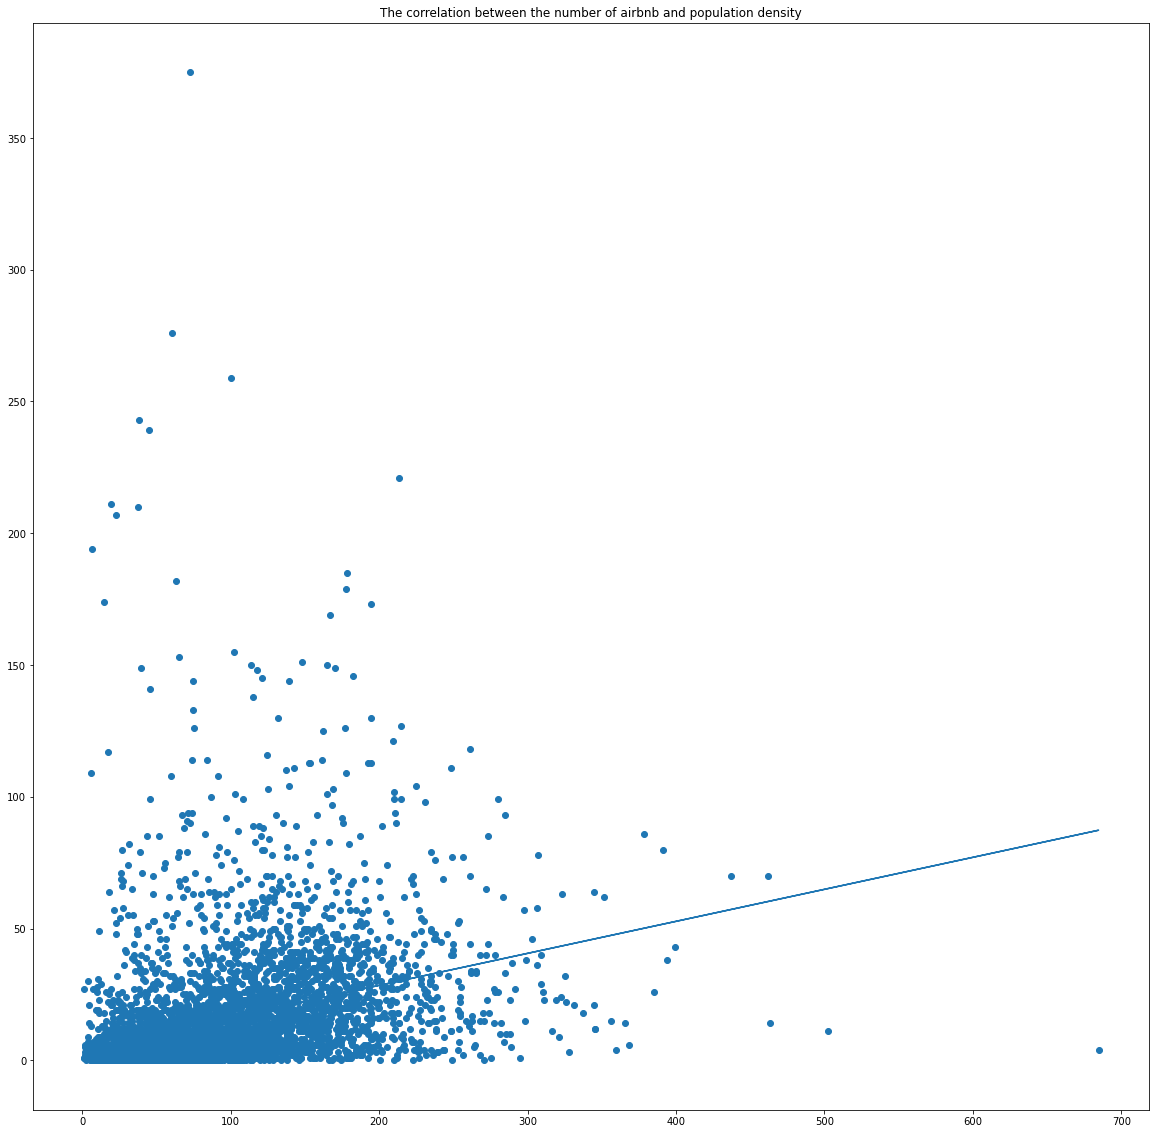

In [27]:
from numpy.polynomial.polynomial import polyfit

f, ax = plt.subplots(1)
plt.scatter(x, y)
b, m = polyfit(x, y, 1)
plt.plot(x, b + m * x, '-')

plt.title("The correlation between the number of airbnb and population density")
# plt.show()
plt.savefig('./output/correlation_airbnb_pop.png')

In [28]:
airbnb = airbnb.merge(lsoas_count, left_on='LSOA11CD', right_on='LSOA11CD')

In [29]:
airbnb

id  host_response_rate  host_acceptance_rate  \
0         13913                1.00                  0.67   
1         89870                1.00                  0.67   
2        108562                0.00                  0.00   
3       3968792                0.00                  0.00   
4       4064636                0.00                  1.00   
...         ...                 ...                   ...   
76509  48052441                0.00                  0.00   
76510  48078717                0.00                  0.00   
76511  48100593                0.88                  0.94   
76512  48100618                0.88                  0.94   
76513  48100847                0.88                  0.94   

       host_identity_verified                              neighbourhood  \
0                        True  Islington, Greater London, United Kingdom   
1                        True                     London, United Kingdom   
2                        True                                      False   
3                        True     London, Greater London, United Kingdom   
4                       False                     London, United Kingdom   
...                       ...                                        ...   
76509                    True                                      False   
76510                   False    Greater London, England, United Kingdom   
76511                    True                                      False   
76512                    True                                      False   
76513                    True                                      False   

       latitude  longitude              property_type        room_type  \
0      51.56802   -0.11121  Private room in apartment     Private room   
1      51.56822   -0.11266           Entire apartment  Entire home/apt   
2      51.56739   -0.11264  Private room in apartment     Private room   
3      51.57045   -0.11498           Entire apartment  Entire home/apt   
4      51.56749   -0.11432      Private room in house     Private room   
...         ...        ...                        ...              ...   
76509  51.49565   -0.39449           Entire apartment  Entire home/apt   
76510  51.64320   -0.13113           Entire apartment  Entire home/apt   
76511  51.37587   -0.21845           Entire apartment  Entire home/apt   
76512  51.37564   -0.21893  Private room in apartment     Private room   
76513  51.37651   -0.22025  Private room in apartment     Private room   

       accommodates  ...        LSOA11NM   MSOA11CD       MSOA11NM    LAD11CD  \
0                 2  ...  Islington 003B  E02000556  Islington 003  E09000019   
1                 5  ...  Islington 003B  E02000556  Islington 003  E09000019   
2                 2  ...  Islington 003B  E02000556  Islington 003  E09000019   
3                 6  ...  Islington 003B  E02000556  Islington 003  E09000019   
4                 2  ...  Islington 003B  E02000556  Islington 003  E09000019   
...             ...  ...             ...        ...            ...        ...   
76509             2  ...   Hounslow 005C  E02000530   Hounslow 005  E09000018   
76510             6  ...    Enfield 020C  E02000296    Enfield 020  E09000010   
76511             1  ...     Sutton 009D  E02000848     Sutton 009  E09000029   
76512             1  ...     Sutton 009D  E02000848     Sutton 009  E09000029   
76513             1  ...     Sutton 009D  E02000848     Sutton 009  E09000029   

         LAD11NM    RGN11CD  RGN11NM  POPDEN    Borough  NUMPOINTS  
0      Islington  E12000007   London   122.5  Islington       38.0  
1      Islington  E12000007   London   122.5  Islington       38.0  
2      Islington  E12000007   London   122.5  Islington       38.0  
3      Islington  E12000007   London   122.5  Islington       38.0  
4      Islington  E12000007   London   122.5  Islington       38.0  
...          ...        ...      ...     ...        ...        ...  
76509   Hounslow  E120

In [30]:
airbnb.to_file(driver='ESRI Shapefile', filename='./output/airbnb_new.shp')

In [31]:
airbnb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 76514 entries, 0 to 76513
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           76514 non-null  int64   
 1   host_response_rate           76514 non-null  float64 
 2   host_acceptance_rate         76514 non-null  float64 
 3   host_identity_verified       76514 non-null  bool    
 4   neighbourhood                76514 non-null  object  
 5   latitude                     76514 non-null  float64 
 6   longitude                    76514 non-null  float64 
 7   property_type                76514 non-null  object  
 8   room_type                    76514 non-null  object  
 9   accommodates                 76514 non-null  int64   
 10  bedrooms                     76514 non-null  float64 
 11  beds                         76514 non-null  float64 
 12  amenities                    76514 non-null  int64  

In [32]:
x_name = ['LSOA11CD','host_response_rate', 'host_acceptance_rate','accommodates', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating','review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','POPDEN', 'NUMPOINTS']

In [33]:
names = ['host_response_rate', 'host_acceptance_rate','accommodates', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating','review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','POPDEN', 'NUMPOINTS']

In [34]:
df_n = airbnb[x_name]
df = airbnb[names]

In [37]:
cols = ['review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']
df_input = df_n[cols]

[2 3 4 ... 1 1 1]


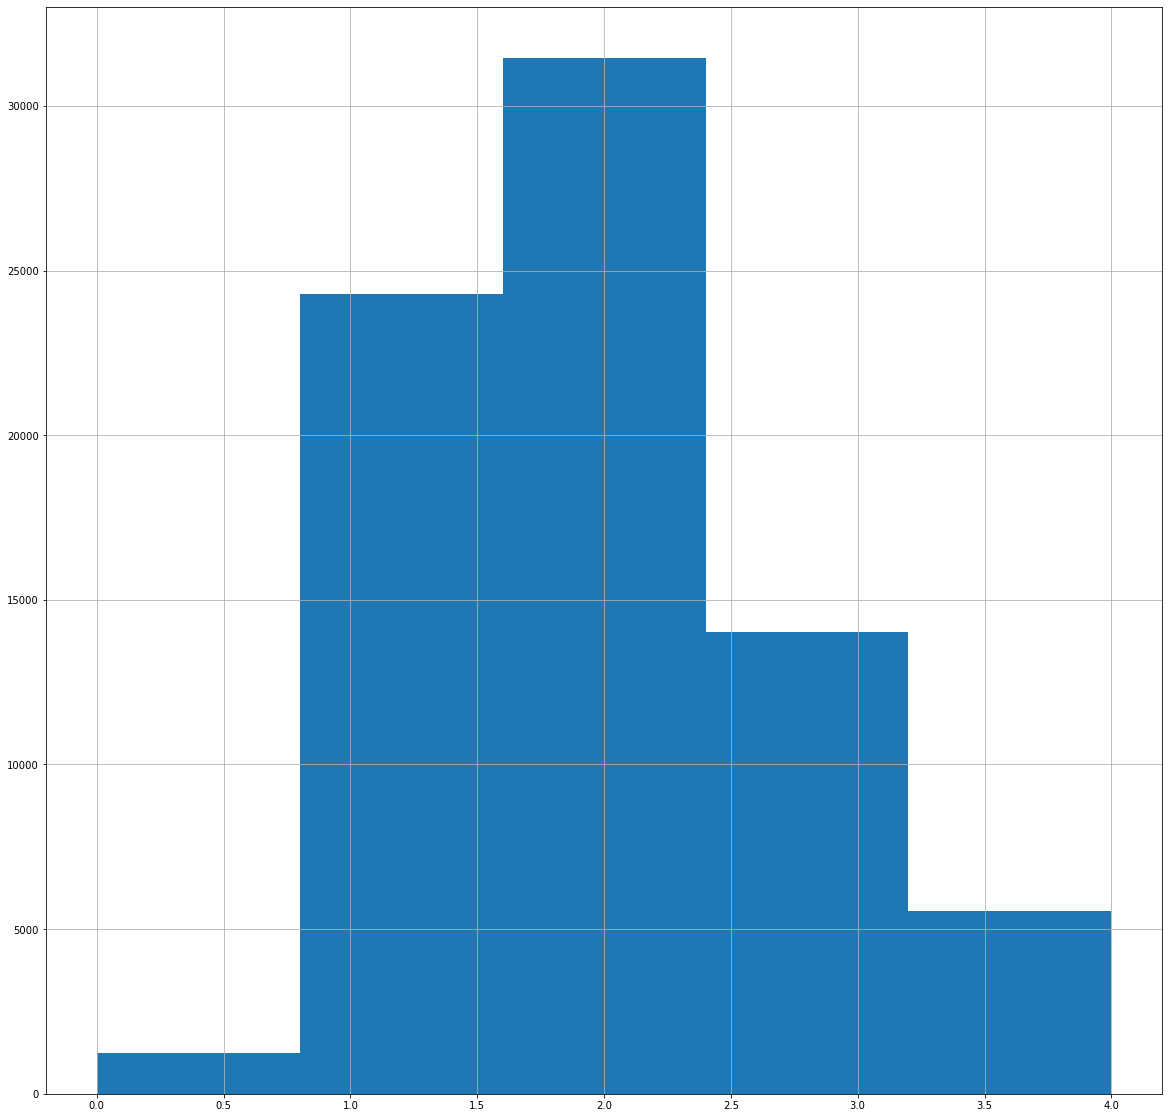

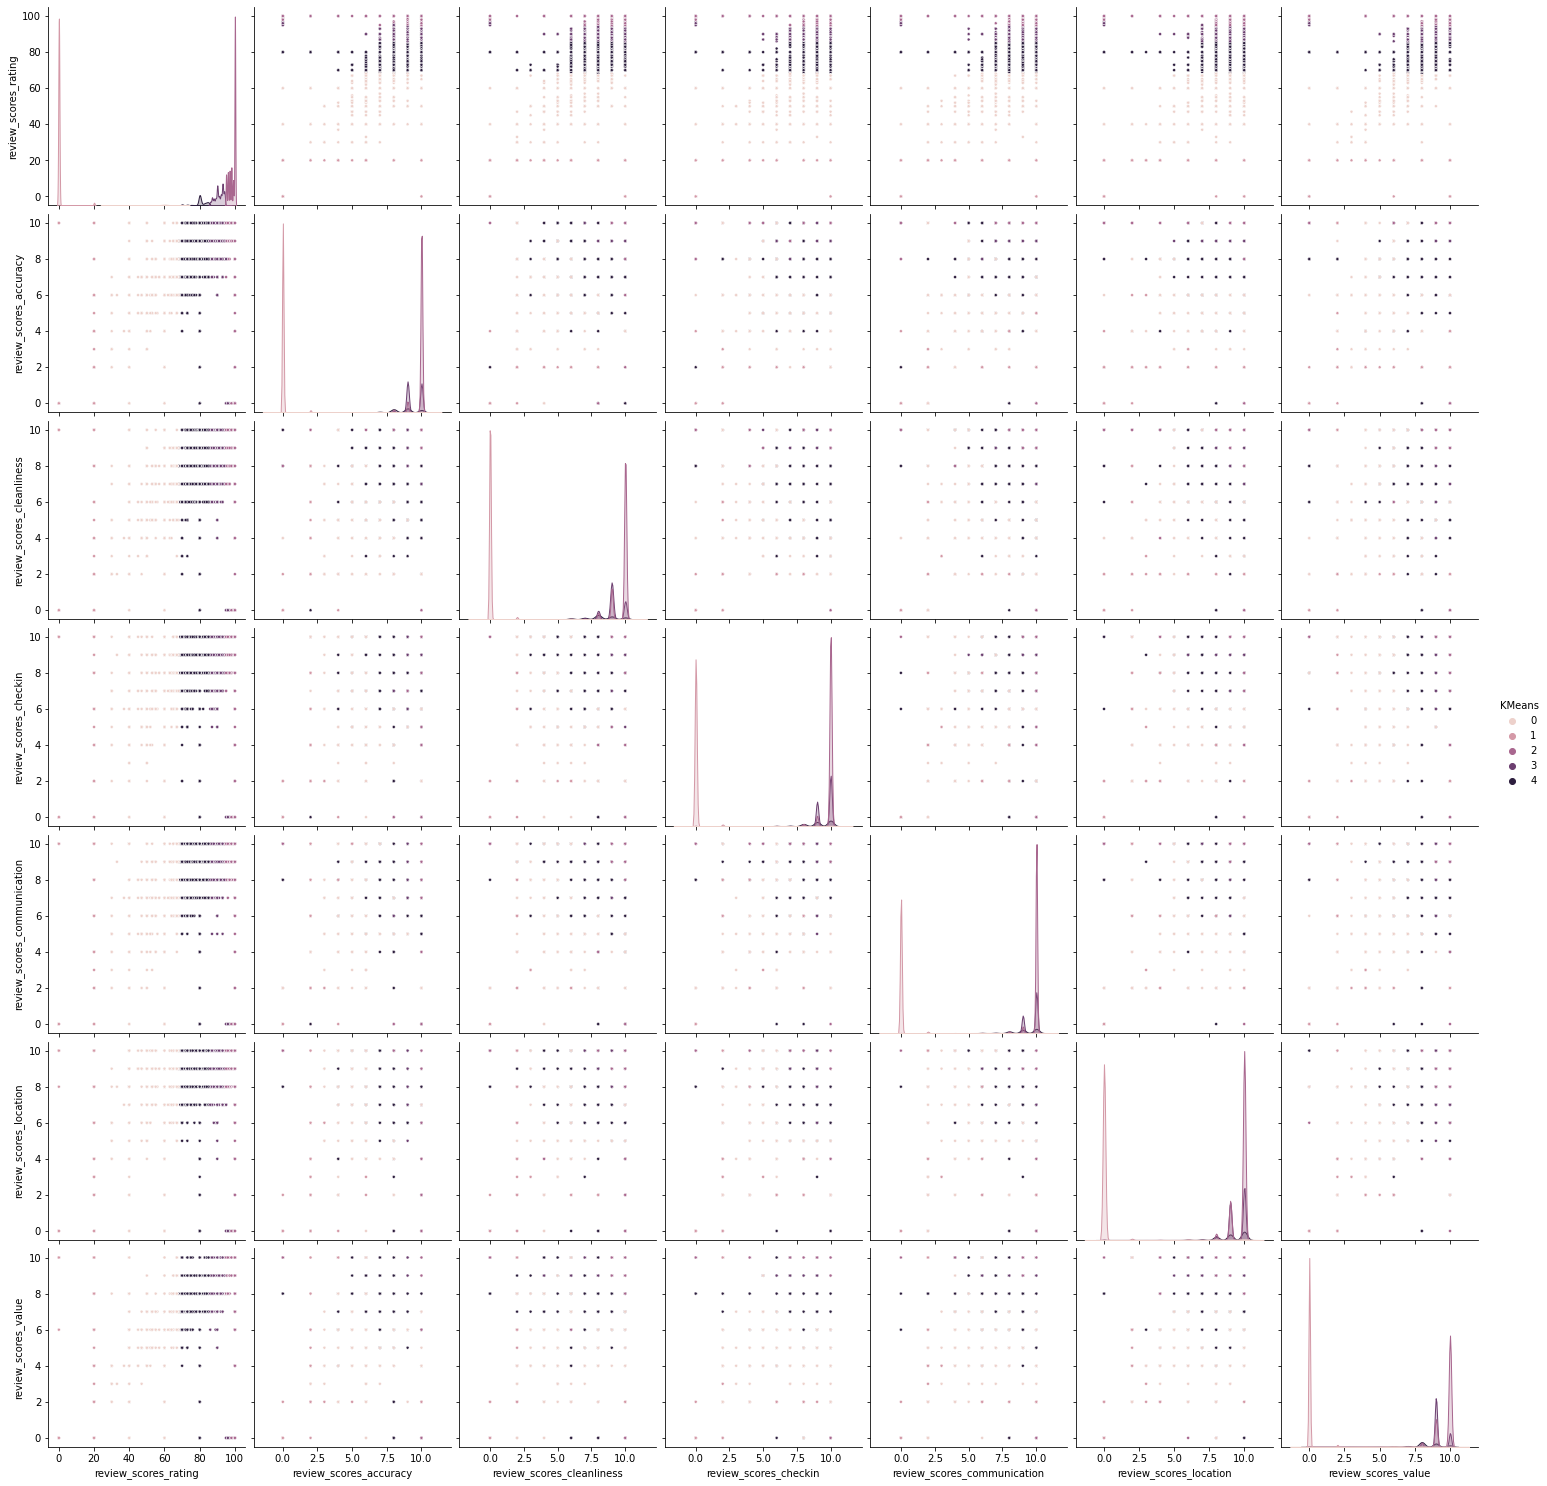

In [38]:
k      = 5 # Number of clusters
k_var  = 'KMeans' # Variable name
kmeans = KMeans(n_clusters=k).fit(df_input) # The process

print(kmeans.labels_) # The results

# Add it to the data frame
df[k_var] = pd.Series(kmeans.labels_, index=df.index) 

# How are the clusters distributed?
df.KMeans.hist(bins=k)

# Going to be a bit hard to read if 
# we plot every variable against every
# other variables, so we'll just pick a 
# few
sns.pairplot(df, 
             vars=cols, 
             hue=k_var, markers=".", height=3, diag_kind='kde')

In [39]:
col = ['review_scores_rating', 
       'review_scores_location', 'review_scores_value']
df_input = df[col]

[0 4 2 ... 1 1 1]


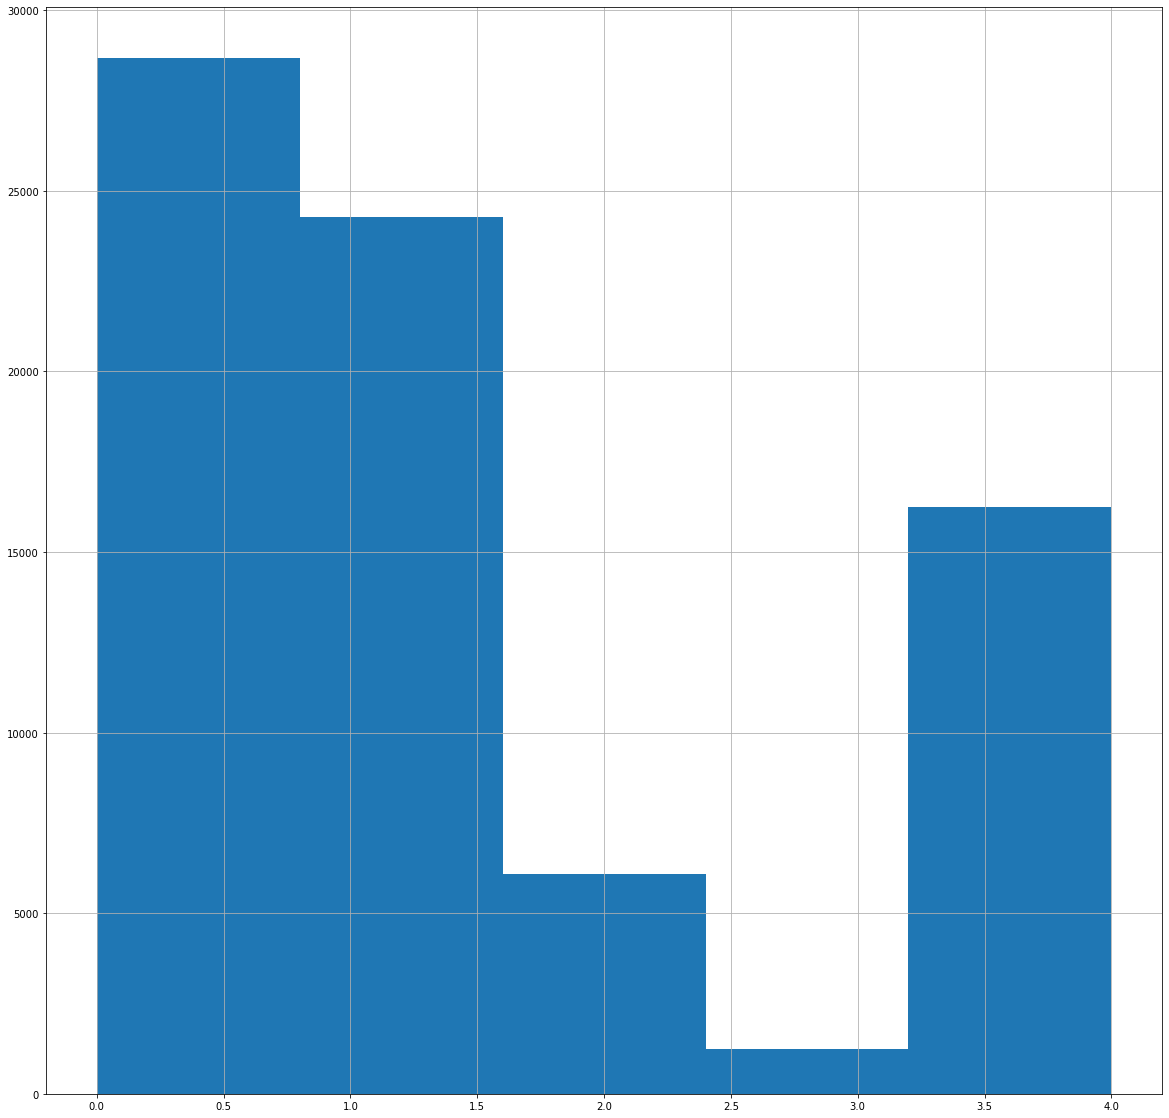

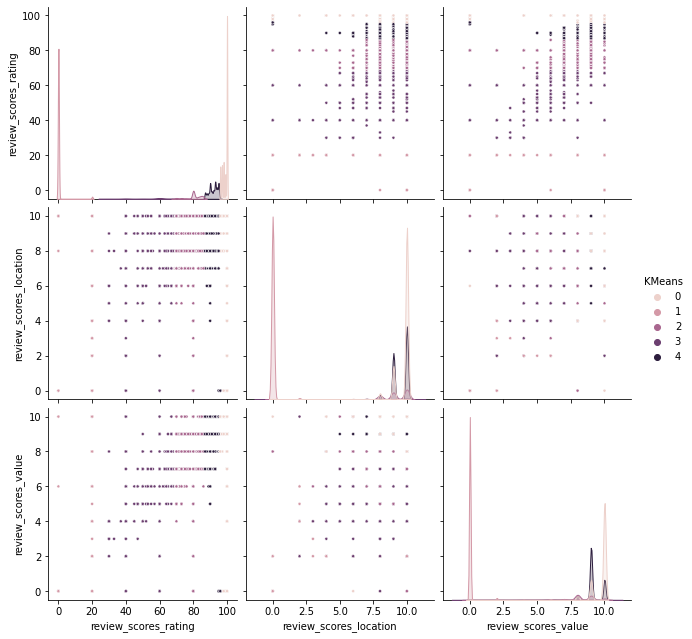

In [40]:
k      = 5 # Number of clusters
k_var  = 'KMeans' # Variable name
kmeans = KMeans(n_clusters=k).fit(df_input) # The process

print(kmeans.labels_) # The results

# Add it to the data frame
df[k_var] = pd.Series(kmeans.labels_, index=df.index) 

# How are the clusters distributed?
df.KMeans.hist(bins=k)

# Going to be a bit hard to read if 
# we plot every variable against every
# other variables, so we'll just pick a 
# few
sns.pairplot(df, 
             vars=col, 
             hue=k_var, markers=".", height=3, diag_kind='kde')

[0 4 2 ... 1 1 1]


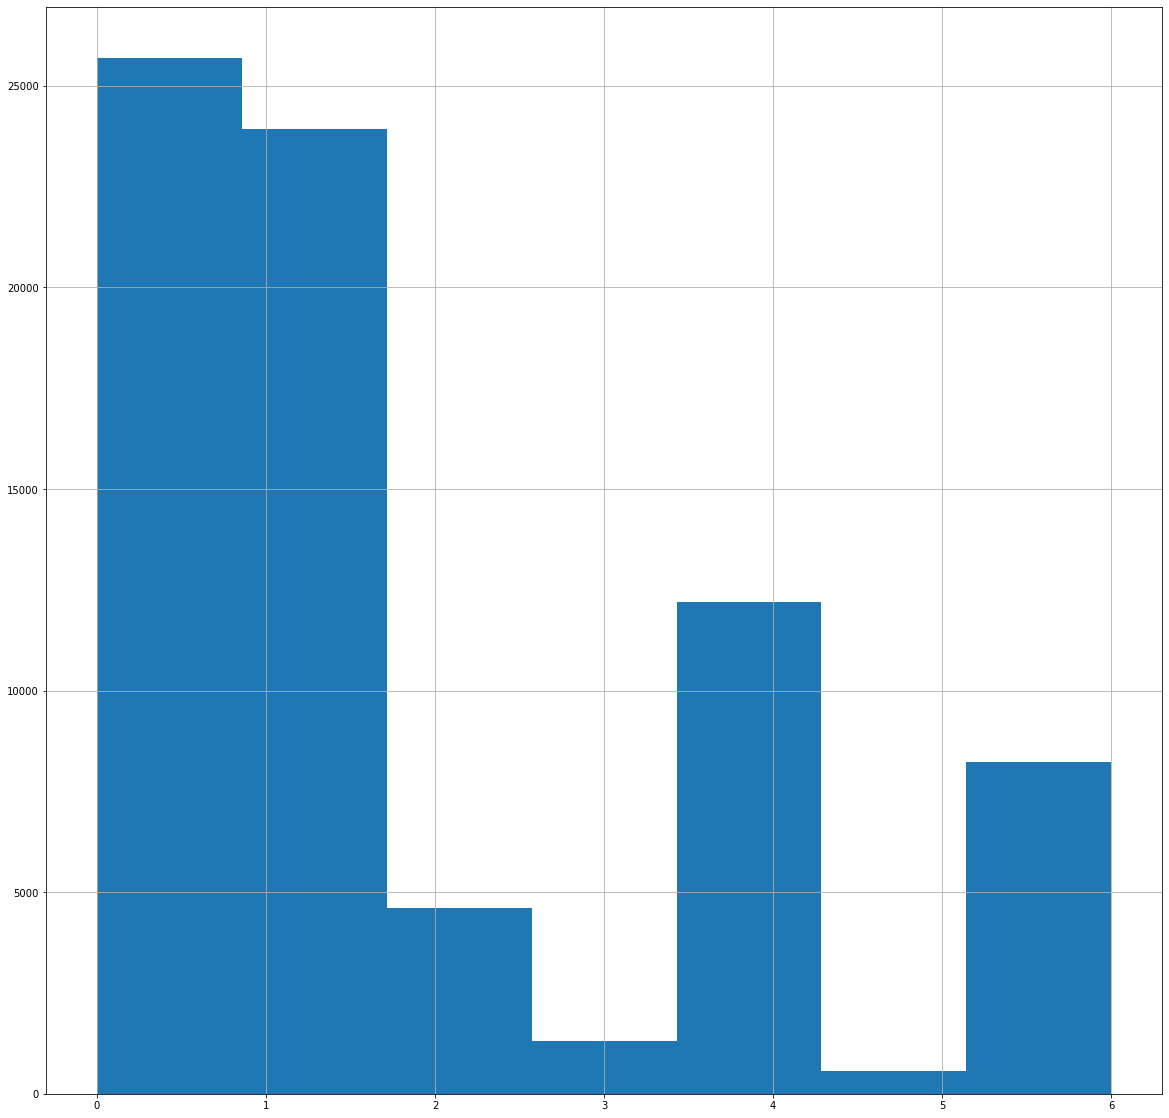

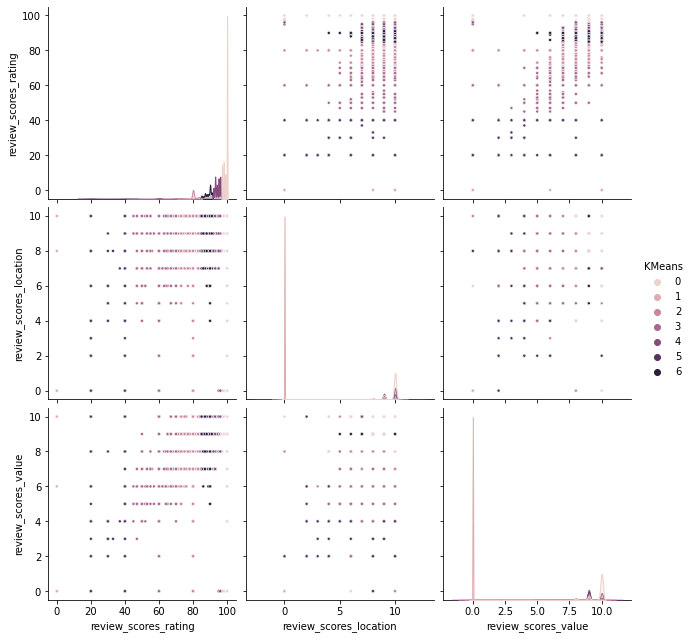

In [41]:
k      = 7 # Number of clusters
k_var  = 'KMeans' # Variable name
kmeans = KMeans(n_clusters=k).fit(df_input) # The process

print(kmeans.labels_) # The results

# Add it to the data frame
df[k_var] = pd.Series(kmeans.labels_, index=df.index) 

# How are the clusters distributed?
df.KMeans.hist(bins=k)

# Going to be a bit hard to read if 
# we plot every variable against every
# other variables, so we'll just pick a 
# few
sns.pairplot(df, 
             vars=col, 
             hue=k_var, markers=".", height=3, diag_kind='kde')

In [47]:
df.columns

Index(['host_response_rate', 'host_acceptance_rate', 'accommodates',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'POPDEN', 'NUMPOINTS',
       'KMeans'],
      dtype='object')

In [52]:
df_nn = df.set_index(df_n['LSOA11CD'])

In [56]:
airbnb = airbnb.set_index(airbnb['LSOA11CD'])

In [57]:
neww = airbnb.merge(df_nn, left_index=True, right_index=True)

In [58]:
neww.columns

Index(['id', 'host_response_rate_x', 'host_acceptance_rate_x',
       'host_identity_verified', 'neighbourhood', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates_x', 'bedrooms_x', 'beds_x',
       'amenities_x', 'price_x', 'minimum_nights_x', 'maximum_nights_x',
       'number_of_reviews_x', 'review_scores_rating_x',
       'review_scores_accuracy_x', 'review_scores_cleanliness_x',
       'review_scores_checkin_x', 'review_scores_communication_x',
       'review_scores_location_x', 'review_scores_value_x', 'instant_bookable',
       'geometry', 'index_right', 'LSOA11CD', 'LSOA11NM', 'MSOA11CD',
       'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'POPDEN_x',
       'Borough', 'NUMPOINTS_x', 'host_response_rate_y',
       'host_acceptance_rate_y', 'accommodates_y', 'bedrooms_y', 'beds_y',
       'amenities_y', 'price_y', 'minimum_nights_y', 'maximum_nights_y',
       'number_of_reviews_y', 'review_scores_rating_y',
       'review_scores_accuracy_y', 

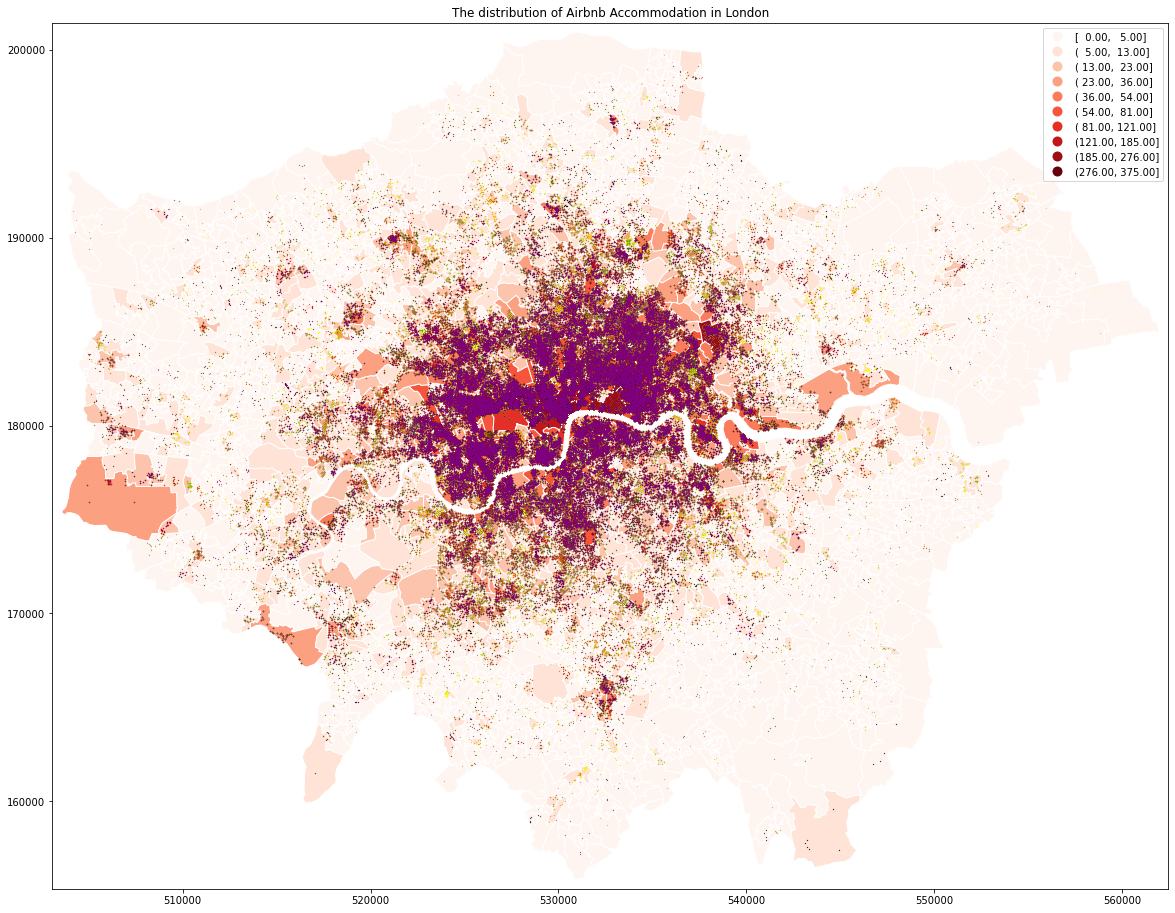

In [59]:
# plot: distribution of airbnb point
figsize(20, 20)

base = lsoas.plot(column='NUMPOINTS', cmap=plt.cm.Reds, k = 10, alpha=1,scheme='fisher_jenks', edgecolor='white', linewidth=1, legend=True)
neww[neww['KMeans'] == 0].plot(ax=base, marker='o', color='black', markersize=0.01)
neww[neww['KMeans'] == 1].plot(ax=base, marker='o', color='yellow', markersize=0.01)
neww[neww['KMeans'] == 2].plot(ax=base, marker='o', color='red', markersize=0.01)
neww[neww['KMeans'] == 3].plot(ax=base, marker='o', color='green', markersize=0.01)
neww[neww['KMeans'] == 4].plot(ax=base, marker='o', color='purple', markersize=0.01)

bounds = lsoas.geometry.bounds
plt.xlim([bounds.minx.min()-500, bounds.maxx.max()+500])
plt.ylim([bounds.miny.min()-500, bounds.maxy.max()+500])
# ax.set_axis_off()
plt.title("The distribution of Airbnb Accommodation in London")
# plt.show()
plt.savefig('./output/kmeans.png')